In [ ]:
from scipy.ndimage import zoom
from scipy.ndimage.filters import gaussian_filter
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np
def resize_image(image, new_shape):
    old_shape = image.shape
    ratio = [n/float(o) for n, o in zip(new_shape, old_shape)]
    return zoom(image, ratio, order=1)  

def vis(seg_filepath, attributions_ig, save_path):
    prob_matrix = np.load(seg_filepath)
    multi_classes = np.zeros((prob_matrix.shape[0],prob_matrix.shape[1]))

    for i in range(prob_matrix.shape[0]):

        for j in range(prob_matrix.shape[1]):
            multi_classes[i][j] = np.argmax(prob_matrix[i,j,:])

            if prob_matrix[i,j,0] == 0 and multi_classes[i][j] == 0:
                multi_classes[i][j] = 1


    a = attributions_ig.detach().numpy()
    a = np.squeeze(a)
    a = abs(a).sum(axis = 0)
    a = a/np.percentile(a.flatten(), 95)
    a = gaussian_filter(a, sigma=1)
 

    plt.figure(figsize=(4,4))
    plt.xticks(())
    plt.yticks(())
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    attri_map = np.squeeze(a)

    b = ["#ce2828", "#FFFFFF", "#9400D3", "#9C755F", "#E15759", "#98FB98", '#00BFFF', "#e6b119"]
    flatui = b
    sns.set_palette(flatui)
    segmap = multi_classes
    cmap = ListedColormap(flatui)

    plt.imshow(segmap, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(flatui)-1)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    alphas = np.clip(attri_map, .7, 1)
    plt.imshow(attri_map,cmap='gray',alpha=1-alphas,extent=(xmin,xmax,ymin,ymax))
    plt.savefig(save_path,bbox_inches='tight',pad_inches = 0,dpi=300)
    return None


In [6]:
from Network.MacroVisionNet import resnext50_32x4d
from captum.attr import Saliency
import torch.nn as nn
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2


def get_Atrrmap(file_path):
    PATH = r'path/to/macro.pkl'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = resnext50_32x4d()
    checkpoint = torch.load(PATH, map_location=device)  
    state_dict = checkpoint['model_state_dict']
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model = nn.DataParallel(model, device_ids=[0])
    model = model.to(device)
    model.eval()

    seg_filepaths = [file_path]
    for seg_filepath in seg_filepaths:

        input_npy = np.load(seg_filepath)
        train_transform = A.Compose(
            [   
                A.Resize(336, 336),
                ToTensorV2(),
            ]
        )
        transformed = train_transform(image=input_npy)
        transformed_image = transformed["image"]
        input_tensor = transformed_image.unsqueeze(0).float()
        saliency = Saliency(model)
        Attrmap = saliency.attribute(input_tensor, target=None,abs=False)
    return Attrmap

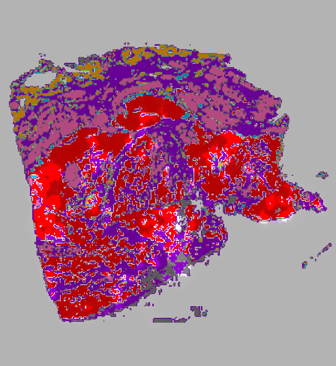

In [3]:
file_path = 'path/to/macro.npy'  
save_path = 'path/to/save.png'   
attrmap = get_Atrrmap(file_path)
vis(file_path, attrmap, save_path)